In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Aircraft parameters
b = 4.0 # wingspan in m
S_w = 2*2*(0.4+0.2)/2 # wing area in m^2
A = b*b/S_w # Aspect ratio 
CL_plane_0  = 0.183 # from XFLR
CL_alpha_plane  = (0.286-0.183)/1.0 # from XFLR 

tip_offset = 0.040 # x distance between root LE and tip LE(Leading edge) in m 
tan_LE_sweep = tip_offset/(0.5*b) #needed for empirical coefficients from Pamadi
c_r = 0.400 # root cord
c_t = 0.200 # tip cord
taper_ratio = c_t/c_r
tan_c4_sweep = tan_LE_sweep - (c_r-c_t)/(2*b)
c4_sweep = np.arctan(tan_c4_sweep)
c_mac = 0.300 # mean aerodynamic cord in m
x_ac_w = 0.090 # distance from leading edge to the aerodynamic center of the wing in m  from XFLR
Cm_ac_w = -0.065 #moment coefficient of the wing at aerodynamic center from XFLR
CL_w_0 = 0.247 # Lift coefficient of the wing at zero AOA from XFLR
CL_alpha_w = 0.09166 # CL vs AOA wing from XFLR

# (0.258 - 0.247) /0.12

S_t = 0.191 # tail area m^2
nu = 1 # tail efficiency 
x_ac_t = 0.080 # distance from leading edge of the tail to the aerodynamic center(AC) of the tail in m from XFLR
x_tail = 1.33 + x_ac_t # distance from LE of the wing to AC of the tail in m
CL_alpha_t = 0.0835 # change in lift of tale with change of LOCAL!! AOA  from XFLR
l_h = x_tail - x_ac_w # distance from wing AC to tail AC m
h_tail = 0.431 # vertical distance between the wing and tail in m

#trim tab effect Pamadi 210
tau = 3.063/5

#### Factors for downwash estimation Pamadi p196
K_A = 1/A - 1/(1+A**1.7)
K_lambda = (10-3*taper_ratio)/7
K_H = (1-h_tail/b)/(((2*l_h)/b)**(1/3))
de_da = 4.44*(K_A*K_lambda*K_H*(np.cos(c4_sweep))**0.5)**1.19
B = (S_t/S_w)*nu * CL_alpha_t*(1-de_da) # grouping together some terms for convenience 



# Longitudinal stability
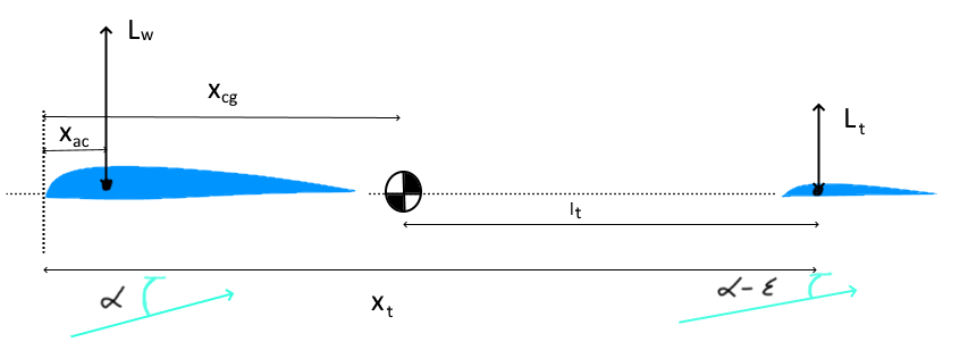

Moment around center of gravity:

$$M = M_{ac} + (x_{cg}-x_{ac})L_w - l_t L_t$$

Making the moment non-dimensional (q is dynamic pressure, c is mean aerodynamic cord)
$$C_m = \frac{M}{qSc}$$

$$C_m = C_{m_{ac}} + \frac{(x_{cg}-x_{ac})}{c} C_{L_w} - \frac{(x_{t}-x_{cg})}{c} \frac{S_t}{S}C_{L_t}\eta$$


Tail experiences downwash, so the apparent AOA is smaller 
$$C_{L_t} = a_t (\alpha - \epsilon)$$




$$\frac{dC_{L_t}}{d\alpha} = a_t(1-\frac{d\epsilon}{d\alpha})$$

$$C_m = C_{m_{ac}} + \frac{(x_{cg}-x_{ac})}{c} \left( \frac{dC_{L_w}}{d\alpha}\alpha +C_{L_{w0}}\right)  - \frac{(x_{t}-x_{cg})}{c} \frac{S_t}{S} a_t(1-\frac{d\epsilon}{d\alpha})\alpha\eta$$


In [2]:
# the most aft limit 
x_cg_aft_limit = (x_ac_w*CL_alpha_w + x_tail*B)/(B+CL_alpha_w)
print("Neutral point: ",x_cg_aft_limit,"[m]")

Neutral point:  0.22501071983470153 [m]


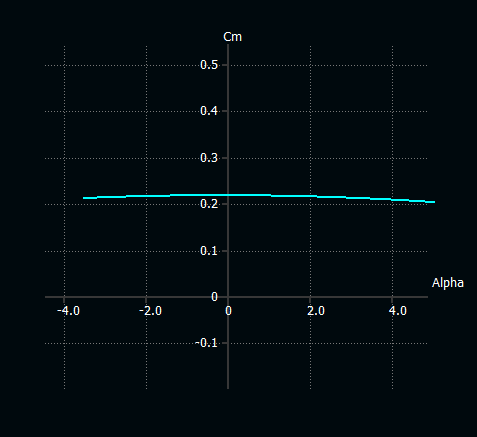

This is the moment coefficient of the plane vs AOA in xflr5 calculated around  $x_{cg} = 0.225[m] $.
The curve is flat, so this is indeed a neutral point 

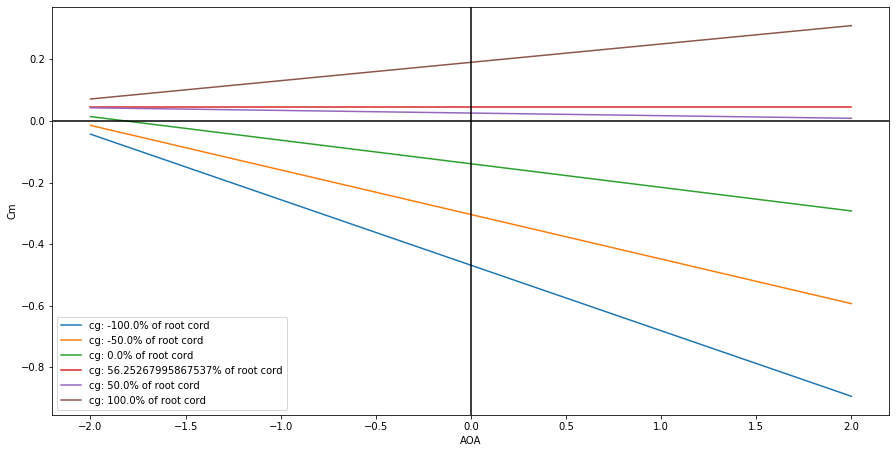

In [3]:
def Cm(AOA,x_cg):
    CL_wing = AOA*CL_alpha_w + CL_w_0
    return Cm_ac_w + CL_wing*(x_cg-x_ac_w)/c_mac - AOA*B*(x_tail-x_cg)/c_mac

AOA = np.linspace(-2,2,200)
x_cg_list= np.array([-1.0, -0.5, 0.0, x_cg_aft_limit/c_r, 0.5, 1.0])* c_r
fig1 = plt.figure(figsize= (15,7.5))
for x_cg in x_cg_list:
    plt.plot(AOA,Cm(AOA,x_cg),label = "cg: "+str(100*x_cg/c_r)+ "% of root cord")
             
plt.xlabel("AOA")
plt.ylabel("Cm")
plt.legend()
 
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()


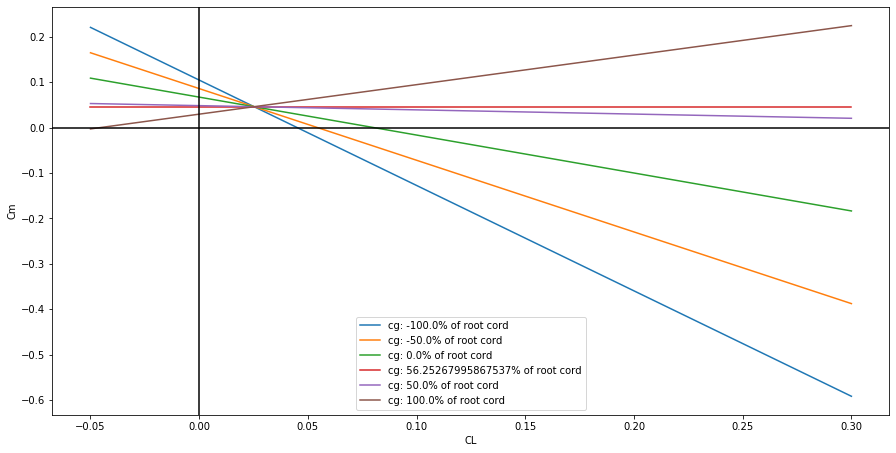

In [4]:

CL = np.linspace(-0.05,0.3,200)
alpha = lambda cl: (cl-CL_w_0)/CL_alpha_w
fig2 = plt.figure(figsize= (15,7.5))
for x_cg in x_cg_list:
    plt.plot(CL,Cm(alpha(CL),x_cg),label = "cg: "+str(100*x_cg/c_r)+ "% of root cord")
             
plt.xlabel("CL")
plt.ylabel("Cm")
plt.legend()

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()


### Forwrd CG limits

Modify $C_m$ equation to include the elevator lift :

$$C_m = C_{m_{ac}} + \frac{(x_{cg}-x_{ac})}{c} \left( \frac{dC_{L_w}}{d\alpha}\alpha +C_{L_{w0}}\right)  - \frac{(x_{t}-x_{cg})}{c} \frac{S_t}{S} a_t(\alpha - \frac{d\epsilon}{d\alpha}\alpha + \tau \delta_e)\eta$$

Given the flight velocity and vehicle mass, we can determine CL, from CL find the Angle of attack, feed AOA and elevator deflection into the equation above and obtain 
We can solve this equation for $x_{cg}$

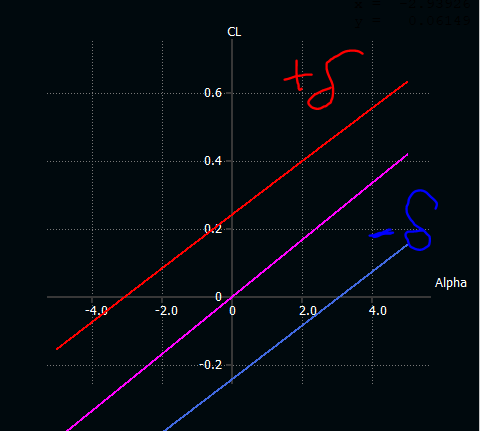

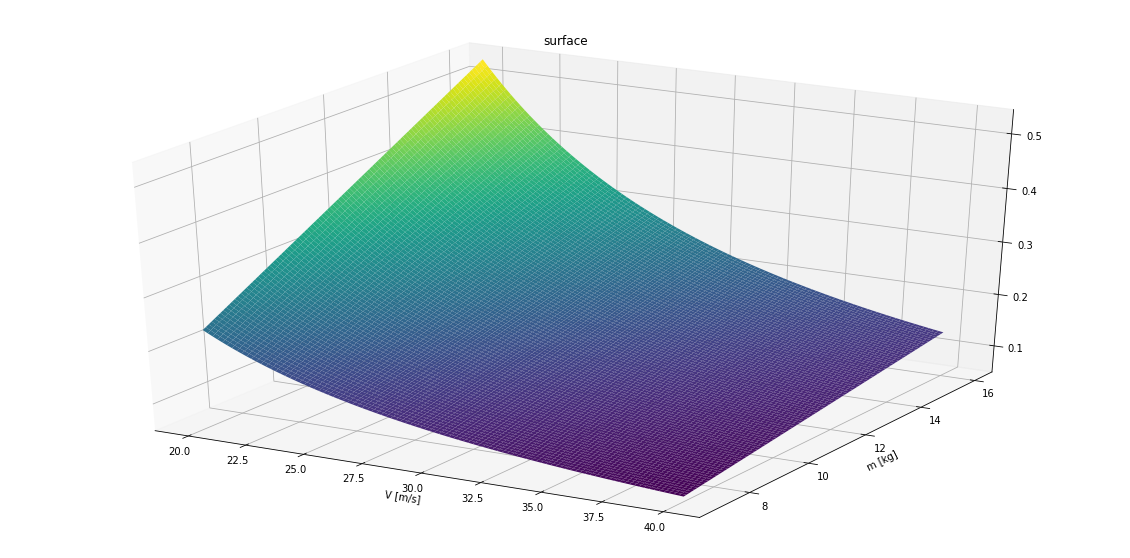

In [6]:
from mpl_toolkits import mplot3d

def x_cg_forward_limit(AOA,trim_max):
    Q = CL_alpha_w*AOA + CL_w_0 
    R = (S_t/S_w) * CL_alpha_t*(AOA - de_da*AOA + trim_max*tau)*nu 
    x = (Q*x_ac_w + x_tail*R - c_mac*Cm_ac_w)/(Q+R)
    return x

m_range = np.linspace(7,16,100)
V_range = np.linspace(20,40,100)
m,V = np.meshgrid(m_range,V_range)
CL = (2*9.81*m)/(1.225*V*V*S_w)
AOA = (CL- CL_plane_0)/CL_alpha_plane

X_cg_max = x_cg_forward_limit(AOA,0)

fig4 = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot_surface(V, m, CL, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.xlabel("V [m/s]")
plt.ylabel("m [kg]")
ax.set_title('surface');
plt.show()